In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from statistics import mean
import math
import datetime
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import Input, Add, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import callbacks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import AffineTransform, warp
from skimage import io, img_as_ubyte
import random
import os
from scipy.ndimage import rotate
import albumentations as A
num = 2000

In [ ]:
images_path ="/content/drive/MyDrive/agv/raw_images"
masks_path = "/content/drive/MyDrive/agv/segmented_images"
img_augmented_path = "/content/drive/MyDrive/agv/aug_raw_img"
msk_augmented_path = "/content/drive/MyDrive/agv/aug_segmented_img "
images= []
masks=[]

In [ ]:
# images_path ="/content/drive/MyDrive/agv/raw_images"
# masks_path = "/content/drive/MyDrive/agv/segmented_images"
# img_augmented_path = "/content/drive/MyDrive/agv/img"
# msk_augmented_path = "/content/drive/MyDrive/agv/test"
# images= []
# masks=[]

In [ ]:
for im in os.listdir(images_path):  # read image name from folder and append its path into "images" array
    images.append(os.path.join(images_path,im))

for msk in os.listdir(masks_path):  # read image name from folder and append its path into "images" array
    masks.append(os.path.join(masks_path,msk))

In [ ]:
aug = A.Compose([
    A.VerticalFlip(p=0.5),
    #A.RandomRotate90(p=1),
    A.HorizontalFlip(p=0.5),
    A.Transpose(p=1),
    #A.RandomBrightness(limit=0.1,p=0.5),
    #A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
    A.GridDistortion(p=1),
    A.Resize(width=256,height=512)
    ]
)


In [ ]:

i=1   # variable to iterate till images_to_generate


while i<=num:
    number = random.randint(0, len(images)-1)  #PIck a number to select an image & mask
    image = images[number]
    mask = masks[number]
    print(image, mask)
    #image=random.choice(images) #Randomly select an image name
    original_image = io.imread(image)
    original_mask = io.imread(mask)

    augmented = aug(image=original_image, mask=original_mask)
    transformed_image = augmented['image']
    transformed_mask = augmented['mask']


    new_image_path= "%s/augmented_image_%s.png" %(img_augmented_path, i)
    new_mask_path = "%s/augmented_mask_%s.png" %(msk_augmented_path, i)
    io.imsave(new_image_path, transformed_image)
    io.imsave(new_mask_path, transformed_mask)
    i =i+1

In [ ]:
keras.__version__

'2.12.0'

In [ ]:
!pip install -U -q segmentation-models
# !pip install -q tensorflow==2.2.1
# !pip install -q keras==2.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
#!pip install segmentation-models
import tensorflow as tf
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
test_i = cv2.imread('/content/drive/MyDrive/agv/img/augmented_image_1.png')
test_i.shape

(512, 256, 3)

In [ ]:
SIZE_X = 512 #Resize images (height  = X, width = Y)
SIZE_Y = 256

In [ ]:
#Capture training image info as a list
train_images = []

for directory_path in glob.glob("/content/drive/MyDrive/agv/aug_raw_img"):
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (SIZE_Y, SIZE_X))
        #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        #train_labels.append(label)
#Convert list to array for machine learning processing
train_images = np.array(train_images)

#Capture mask/label info as a list
train_masks = []
for directory_path in glob.glob("/content/drive/MyDrive/agv/aug_segmented_img "):
    for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        #mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
        #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
        train_masks.append(mask)
        #train_labels.append(label)
#Convert list to array for machine learning processing
train_masks = np.array(train_masks)

#Use customary x_train and y_train variables
X = train_images
Y = train_masks

In [ ]:
train_images.shape


(2000, 512, 256, 3)

In [ ]:
train_masks.shape

(2000, 512, 256)

In [ ]:
x_train1 = X[:250]
y_train1 = Y[:250]
y_train1.shape

(250, 512, 256)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose

def unet(input_shape=(512, 256, 3)):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bridge
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2DTranspose(512, 2, strides=(2, 2), padding='same')(drop5)
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same')(conv9)

    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Instantiate the U-Net model
model = unet()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, batch_size=16, epochs=10, validation_data=(x_val, y_val))

# # Perform inference on new images
# predictions = model.predict(x_test)

Epoch 1/10
100/100 [==============================] - 251s 2s/step - loss: -1413.0125 - accuracy: 0.0064 - val_loss: -1418.6353 - val_accuracy: 0.0000e+00
Epoch 2/10
100/100 [==============================] - 182s 2s/step - loss: -1439.3838 - accuracy: 0.0000e+00 - val_loss: -1418.6353 - val_accuracy: 0.0000e+00
Epoch 3/10
100/100 [==============================] - 181s 2s/step - loss: -1439.3838 - accuracy: 0.0000e+00 - val_loss: -1418.6353 - val_accuracy: 0.0000e+00
Epoch 4/10
100/100 [==============================] - 181s 2s/step - loss: -1439.3833 - accuracy: 0.0000e+00 - val_loss: -1418.6353 - val_accuracy: 0.0000e+00
Epoch 5/10
100/100 [==============================] - 191s 2s/step - loss: -1439.3839 - accuracy: 0.0000e+00 - val_loss: -1418.6353 - val_accuracy: 0.0000e+00
Epoch 6/10
100/100 [==============================] - 182s 2s/step - loss: -1439.3840 - accuracy: 0.0000e+00 - val_loss: -1418.6353 - val_accuracy: 0.0000e+00
Epoch 7/10
100/100 [==============================

In [ ]:
model.save("/content/drive/MyDrive/agv/model_unet_gpt")

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/agv/model_2000.h5', compile=False)

In [ ]:
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

In [ ]:
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['mse'])
#print(model.summary())

85521592/85521592 [==============================] - 1s 0us/step


In [ ]:
history=model.fit(x_train,
          y_train,
          batch_size=8,
          epochs=500,
          verbose=1,
          validation_data=(x_val, y_val))

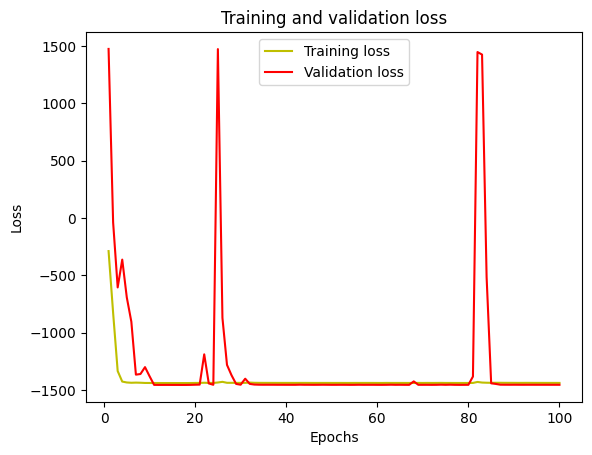

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save("/content/drive/MyDrive/agv/model_2000_aug.h5")

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/agv/model_2000.h5', compile=False)

In [ ]:
test_img = cv2.imread('/content/drive/MyDrive/agv/raw_images/bremen_000156_000019_leftImg8bit.png', cv2.IMREAD_COLOR)
test_img = cv2.rotate(test_img, cv2.ROTATE_90_CLOCKWISE)
test_img = cv2.resize(test_img, (512, 256))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

1/1 [==============================] - 3s 3s/step


In [ ]:
test_i = cv2.imread('/content/drive/MyDrive/agv/raw_images/bremen_000156_000019_leftImg8bit.png')
test_i.shape

(256, 512, 3)

In [ ]:
prediction_image = prediction.reshape(mask.shape)
prediction_image = cv2.rotate(prediction_image, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(prediction_image, cmap='gray')
plt.show()
plt.imshow(test_i, cmap='gray')
plt.show()

In [ ]:

#Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code
#accuracy = model.evaluate(x_val, y_val)
#plot the training and validation accuracy and loss at each epoch
#model.save('membrane.h5')
#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/drive/MyDrive/agv/raw_images/aachen_000064_000019_leftImg8bit.png', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

prediction = model.predict(test_img)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
plt.imsave('membrane/test0_segmented.jpg', prediction_image, cmap='gray')